In [32]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.measure import label
from scipy.ndimage import center_of_mass

In [2]:
t1_path = 't1.nii.gz'
seg1_path = 'seg1.nii.gz'
seg2_path = 'seg2.nii.gz'

In [3]:
t1_sitk = sitk.ReadImage(t1_path)
seg1_sitk = sitk.ReadImage(seg1_path)
seg2_sitk = sitk.ReadImage(seg2_path)

In [4]:
print(t1_sitk.GetSize())
print(seg1_sitk.GetSize())
print(seg2_sitk.GetSize())

(160, 256, 256)
(160, 256, 256)
(160, 256, 256)


In [5]:
print(t1_sitk.GetSpacing())
print(seg1_sitk.GetSpacing())
print(seg2_sitk.GetSpacing())

(1.000001072883606, 1.0, 1.0)
(1.000001072883606, 1.0, 1.0)
(1.000001072883606, 1.0, 1.0)


In [6]:
def calculate_overlap_measures(target: sitk.Image, prediction: sitk.Image) -> dict:
    """
    Caclulate overlap measures between two SimpleITK image labelmaps.
    Specifically, Jaccard similarity coefficient, Dice overlap, volume similarity, number of false positives
    and number of false negatives.
    
    Adapted from http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/34_Segmentation_Evaluation.html
    """
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_measures_filter.Execute(prediction, target)
    
    overlap_measures = {}
    
    overlap_measures['jaccard'] = overlap_measures_filter.GetJaccardCoefficient()
    overlap_measures['dice'] = overlap_measures_filter.GetDiceCoefficient()
    overlap_measures['volume_similarity'] = overlap_measures_filter.GetVolumeSimilarity()
    overlap_measures['false_negative'] = overlap_measures_filter.GetFalseNegativeError()
    overlap_measures['false_positive'] = overlap_measures_filter.GetFalsePositiveError()
    
    # Round metric to 3dp: 
    overlap_measures = {k: round(v, 3) for k, v in overlap_measures.items()}
    
    return overlap_measures

In [12]:
def calculate_surface_distance_measures(target: sitk.Image, prediction: sitk.Image) -> dict:
    """
    Calculate distance measures between two SimpleITK image labelmaps.
    Specifically, Hausdorff distance, mean, median, standard deviation and maximum surface distances.
    Returns dic
    Adapted from http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/34_Segmentation_Evaluation.html
    """
    surface_distance_measures = {}
    
    hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()
    
    label = 1
    reference_distance_map = sitk.Abs(sitk.SignedMaurerDistanceMap(target, squaredDistance=False, useImageSpacing=True))
    reference_surface = sitk.LabelContour(target)

    statistics_image_filter = sitk.StatisticsImageFilter()
    # Get the number of pixels in the reference surface by counting all pixels that are 1.
    statistics_image_filter.Execute(reference_surface)
    num_reference_surface_pixels = int(statistics_image_filter.GetSum()) 
    
    # Hausdorff distance
    hausdorff_distance_filter.Execute(target, prediction)
    
    surface_distance_measures['hausdorff_distance'] = hausdorff_distance_filter.GetHausdorffDistance()
    # Symmetric surface distance measures
    segmented_distance_map = sitk.Abs(sitk.SignedMaurerDistanceMap(prediction, squaredDistance=False, useImageSpacing=True))
    segmented_surface = sitk.LabelContour(prediction)
        
    # Multiply the binary surface segmentations with the distance maps. The resulting distance
    # maps contain non-zero values only on the surface (they can also contain zero on the surface)
    seg2ref_distance_map = reference_distance_map*sitk.Cast(segmented_surface, sitk.sitkFloat32)
    ref2seg_distance_map = segmented_distance_map*sitk.Cast(reference_surface, sitk.sitkFloat32)
        
    # Get the number of pixels in the reference surface by counting all pixels that are 1.
    statistics_image_filter.Execute(segmented_surface)
    num_segmented_surface_pixels = int(statistics_image_filter.GetSum())
    
    # Get all non-zero distances and then add zero distances if required.
    seg2ref_distance_map_arr = sitk.GetArrayViewFromImage(seg2ref_distance_map)
    seg2ref_distances = list(seg2ref_distance_map_arr[seg2ref_distance_map_arr!=0]) 
    seg2ref_distances = seg2ref_distances + \
                        list(np.zeros(num_segmented_surface_pixels - len(seg2ref_distances)))
    ref2seg_distance_map_arr = sitk.GetArrayViewFromImage(ref2seg_distance_map)
    ref2seg_distances = list(ref2seg_distance_map_arr[ref2seg_distance_map_arr!=0]) 
    ref2seg_distances = ref2seg_distances + \
                        list(np.zeros(num_reference_surface_pixels - len(ref2seg_distances)))
        
    all_surface_distances = seg2ref_distances + ref2seg_distances

    # The maximum of the symmetric surface distances is the Hausdorff distance between the surfaces. In 
    # general, it is not equal to the Hausdorff distance between all voxel/pixel points of the two 
    # segmentations, though in our case it is. More on this below.
    surface_distance_measures['mean_surface_distance'] = np.mean(all_surface_distances)
    surface_distance_measures['median_surface_distance'] = np.median(all_surface_distances)
    surface_distance_measures['std_surface_distance'] = np.std(all_surface_distances)
    surface_distance_measures['max_surface_distance'] = np.max(all_surface_distances)
    
    # Round metric to 3dp: 
    surface_distance_measures = {k: round(v, 3) for k, v in surface_distance_measures.items()}
    
    return surface_distance_measures

In [38]:
def centre_of_mass_segmentation(segmentation, axis=0):
    """Return index of centre of mass of binary segmentation"""
    labels = label(segmentation)
    return int(center_of_mass(labels)[axis])

In [50]:
def plot_segmentation(image, seg1, seg2, name):
    """ plot image, and assosciated target and predicted segementation masks """
    slice_ = centre_of_mass_segmentation(seg1)
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, 1)
    plt.title(name)
    plt.imshow(np.flip(image[slice_, :, :]), cmap='gray')
    plt.subplot(1, 4, 2)
    plt.title('segmentation 1')
    plt.imshow(np.flip(seg1[slice_, :, :]))
    plt.subplot(1, 4, 3)
    plt.title('segmentation 2')
    plt.imshow(np.flip(seg2[slice_, :, :]))
    
    diff = seg1 - seg2
    plt.subplot(1, 4, 4)
    plt.title('difference')
    plt.imshow(np.flip(diff[slice_, :, :]))
    
    plt.show()

In [18]:
overlap_list = []
for i in range(0, 6):
    overlap_list.append(calculate_overlap_measures(seg1_sitk == i, seg2_sitk == i))
    overlap_df = pd.DataFrame(overlap_list)
print(overlap_df)

   jaccard   dice  volume_similarity  false_negative  false_positive
0    1.000  1.000              0.000           0.000           0.281
1    0.802  0.890              0.059           0.083           0.000
2    0.447  0.618              0.537           0.156           0.000
3    0.675  0.806              0.021           0.185           0.000
4    0.421  0.592             -0.282           0.481           0.000
5    0.401  0.573             -0.031           0.436           0.000


In [19]:
surface_list = []
for i in range(0, 6):
    surface_list.append(calculate_surface_distance_measures(seg1_sitk == i, seg2_sitk == i))
    surface_df = pd.DataFrame(surface_list)
print(surface_df)

   hausdorff_distance  mean_surface_distance  median_surface_distance  \
0               3.000                  0.500                      0.0   
1               1.732                  0.181                      0.0   
2               1.414                  0.428                      0.0   
3               4.583                  0.323                      0.0   
4              11.747                  1.301                      1.0   
5               4.472                  0.788                      1.0   

   std_surface_distance  max_surface_distance  
0                 0.757                 5.385  
1                 0.391                 1.732  
2                 0.505                 1.414  
3                 0.568                 4.583  
4                 2.213                11.747  
5                 0.910                 4.472  


In [36]:
t1_array = sitk.GetArrayFromImage(t1_sitk)
pituitary_array1 = sitk.GetArrayFromImage(seg1_sitk == 1)
pituitary_array2 = sitk.GetArrayFromImage(seg2_sitk == 1)

Label 1


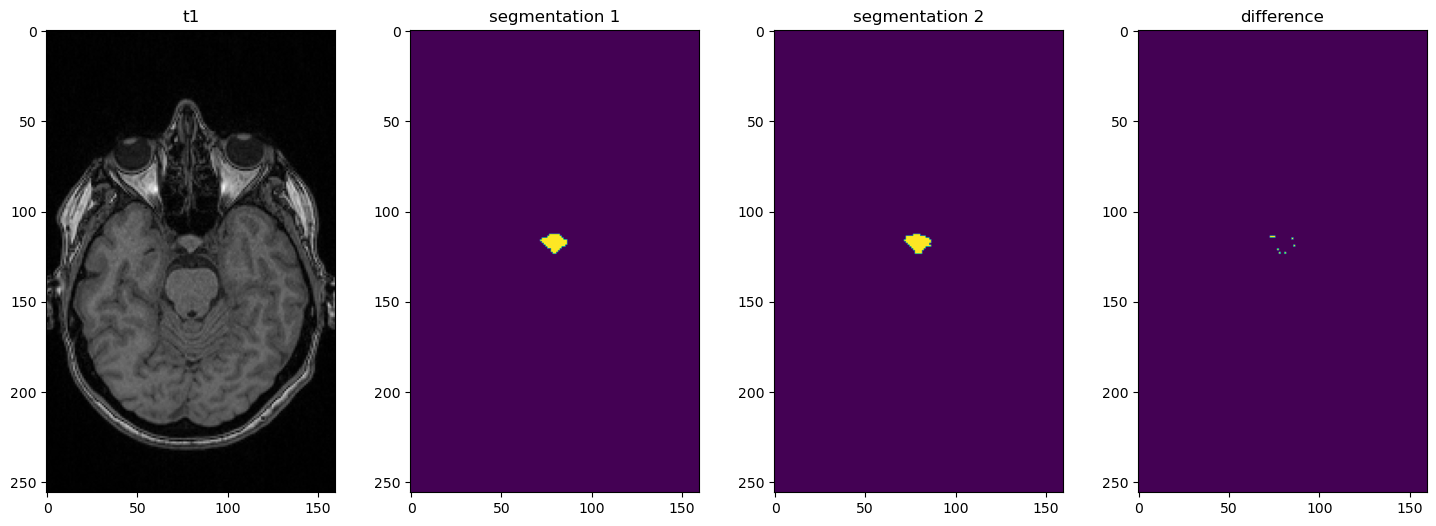

Label 2


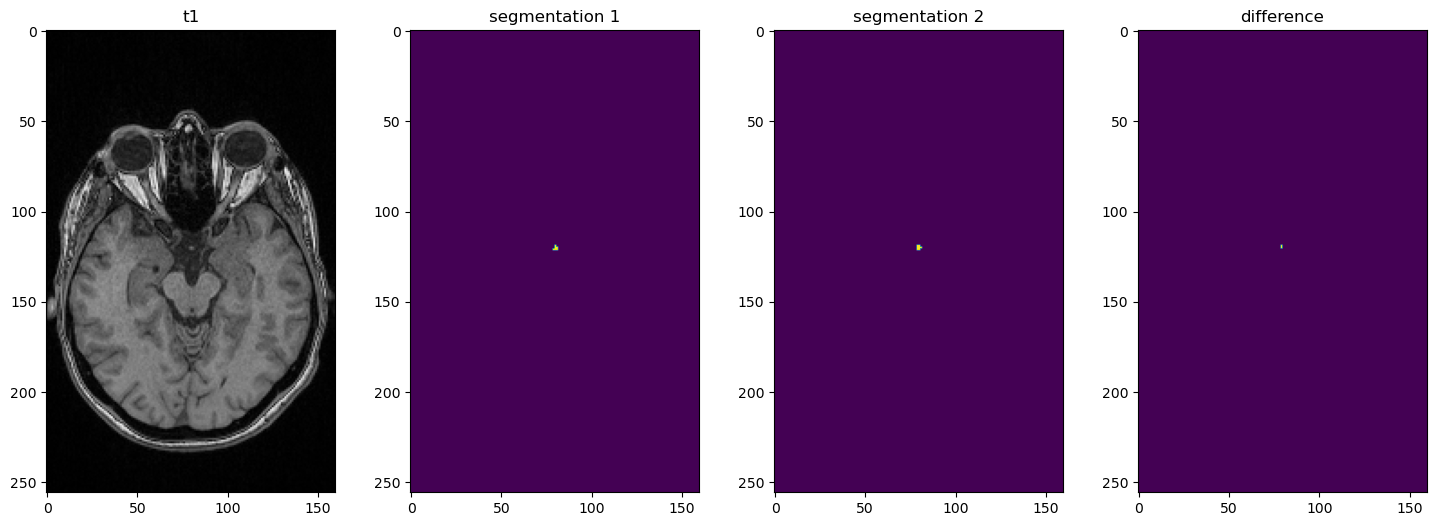

Label 3


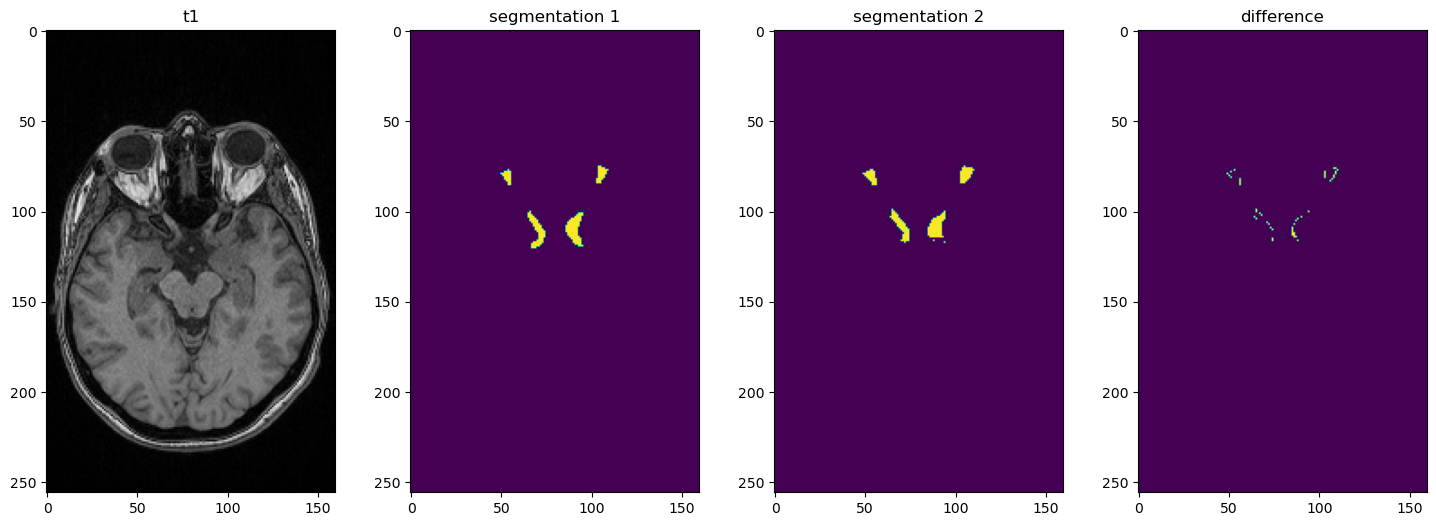

Label 4


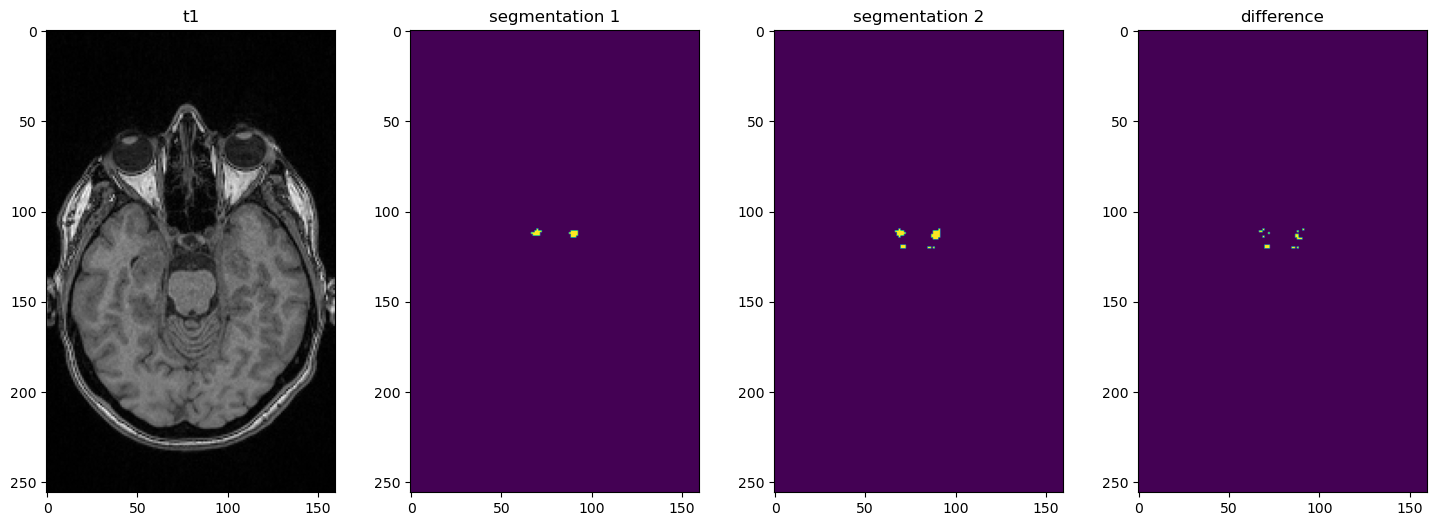

Label 5


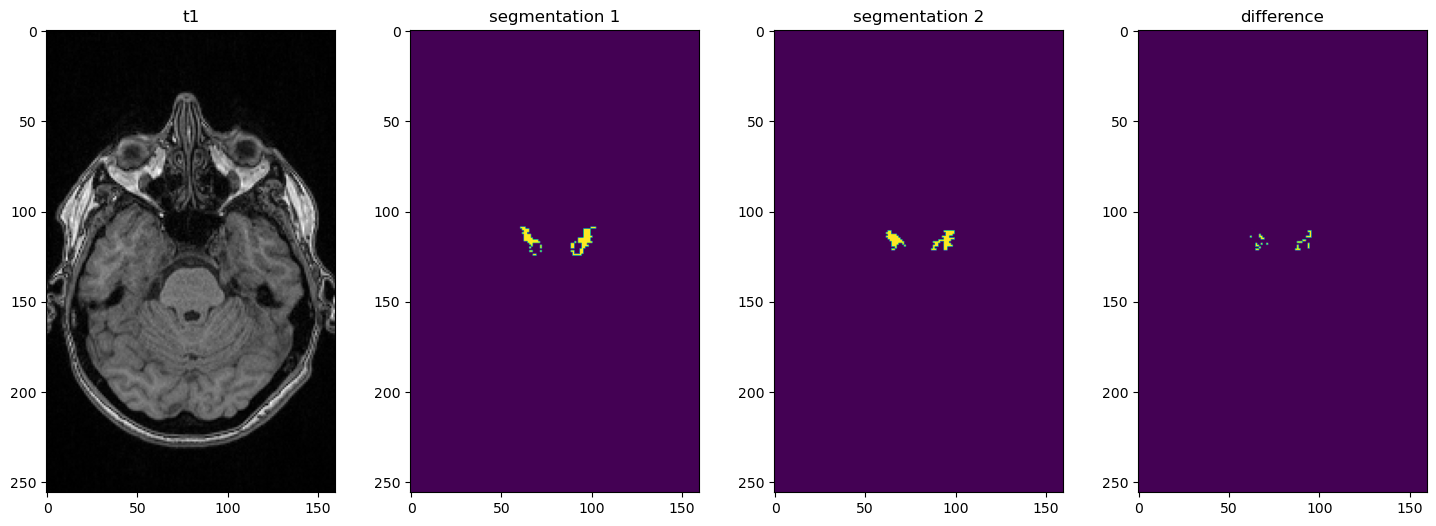

In [53]:
for i in range(1, 6):
    print(f'Label {i}')
    t1_array = sitk.GetArrayFromImage(t1_sitk)
    seg_array1 = sitk.GetArrayFromImage(seg1_sitk == i)
    seg_array2 = sitk.GetArrayFromImage(seg2_sitk == i)
    plot_segmentation(t1_array, seg_array1, seg_array2, 't1')